#Treinamento da Rede U-NeT para segmentação da região do pulmão

In [1]:
# Monta o drive para ler os dados salvos no mesmo
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip3 install pickle5
import pickle5 as pickle

In [3]:
import os
#import pickle
import cv2
import nibabel as nib
import numpy as np

import tensorflow as tf
from tensorflow.keras import Model,layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

In [4]:
def normImage(image):
    image-=np.min(image)
    image = (image/np.max(image))*255
    return image.astype('uint8')

In [5]:
def get_model(IMG_HEIGHT, IMG_WIDTH, CHANNELS):
    in1 = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS ))

    conv1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(in1)
    conv1 = layers.Dropout(0.2)(conv1)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = layers.Dropout(0.2)(conv2)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = layers.Dropout(0.2)(conv3)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    conv4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = layers.Dropout(0.2)(conv4)
    conv4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)

    up1 = layers.concatenate([layers.UpSampling2D((2, 2))(conv4), conv3], axis=-1)
    conv5 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up1)
    conv5 = layers.Dropout(0.2)(conv5)
    conv5 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)
    
    up2 = layers.concatenate([layers.UpSampling2D((2, 2))(conv5), conv2], axis=-1)
    conv6 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
    conv6 = layers.Dropout(0.2)(conv6)
    conv6 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

    up2 = layers.concatenate([layers.UpSampling2D((2, 2))(conv6), conv1], axis=-1)
    conv7 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
    conv7 = layers.Dropout(0.2)(conv7)
    conv7 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    segmentation = layers.Conv2D(1, (1, 1), activation='sigmoid', name='seg')(conv7)

    model = Model(inputs=[in1], outputs=[segmentation])

    losses = {'seg': 'binary_crossentropy'
            }

    metrics = {'seg': ['acc']
                }
    model.compile(optimizer="adam", loss = losses, metrics=metrics)

    return model

In [6]:
masks_path = "/content/gdrive/MyDrive/dados/lungs_masks"        #mascaras marcadas manualmente
ct2_path = "/content/gdrive/MyDrive/COVID19_1110/studies/CT-2"  #TCs

In [7]:
#Gerar os dados de treino e teste
train_data = []
train_labels = []
test_data = []
test_labels = []

masks_names = os.listdir(masks_path)
for nfile,file in enumerate(masks_names):
    #Carregar o arquivo das mascaras
    with open(os.path.join(masks_path,file), 'rb') as handle:
        masks = pickle.load(handle)
    #carrecar o arquivo das imagens de CT
    full_ct_path = os.path.join(ct2_path, file.split('.pickle')[0]) 
    ct_image = nib.load(full_ct_path)
    
    for scn in range(ct_image.dataobj.shape[-1]):
        orig_img = ct_image.dataobj[:,:,scn].copy()
        norm_img = normImage(orig_img) 
        
        img_mask = np.zeros((512,512),dtype = 'uint8')
        img_mask[masks[scn]]=255
        
        norm_img = cv2.resize(norm_img,(256,256),cv2.INTER_LINEAR)
        img_mask = cv2.resize(img_mask,(256,256),cv2.INTER_LINEAR)
        img_mask[img_mask>0]=1
        
        norm_img=norm_img.astype('float64')
        norm_img/=np.max(norm_img)
        img_mask=img_mask.astype('float64')
        
        if nfile<8:
            train_data.append(norm_img.copy())
            train_labels.append(img_mask.copy())
        else:
            test_data.append(norm_img.copy())
            test_labels.append(img_mask.copy())

In [8]:
#Remodelar os dados  
train_data=np.array(train_data)
train_data = train_data.reshape((train_data.shape[0],train_data.shape[1],train_data.shape[2],1))
train_labels=np.array(train_labels)
train_labels = train_labels.reshape((train_labels.shape[0],train_labels.shape[1],train_labels.shape[2],1))

test_data=np.array(test_data)
test_data = test_data.reshape((test_data.shape[0],test_data.shape[1],test_data.shape[2],1))
test_labels=np.array(test_labels)
test_labels = test_labels.reshape((test_labels.shape[0],test_labels.shape[1],test_labels.shape[2],1))

In [9]:
#criar modelo
model = get_model(IMG_HEIGHT=train_data.shape[1], 
                  IMG_WIDTH=train_data.shape[2], 
                  CHANNELS=train_data.shape[3])


Epoch 1/500
11/11 [==============================] - 26s 1s/step - loss: 0.6128 - acc: 0.7921 - val_loss: 0.4844 - val_acc: 0.8470
Epoch 2/500
11/11 [==============================] - 6s 540ms/step - loss: 0.3742 - acc: 0.8610 - val_loss: 0.3190 - val_acc: 0.8470
Epoch 3/500
11/11 [==============================] - 6s 541ms/step - loss: 0.3148 - acc: 0.8610 - val_loss: 0.3133 - val_acc: 0.8470
Epoch 4/500
11/11 [==============================] - 6s 537ms/step - loss: 0.3070 - acc: 0.8610 - val_loss: 0.2950 - val_acc: 0.8470
Epoch 5/500
11/11 [==============================] - 6s 538ms/step - loss: 0.3033 - acc: 0.8610 - val_loss: 0.2952 - val_acc: 0.8470
Epoch 6/500
11/11 [==============================] - 6s 536ms/step - loss: 0.2818 - acc: 0.8610 - val_loss: 0.2992 - val_acc: 0.8470
Epoch 7/500
11/11 [==============================] - 6s 535ms/step - loss: 0.2519 - acc: 0.8610 - val_loss: 0.2780 - val_acc: 0.8470
Epoch 8/500
11/11 [==============================] - 6s 529ms/step - lo

Text(0.5, 1.0, 'acurácia')

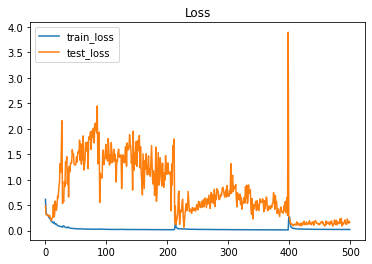

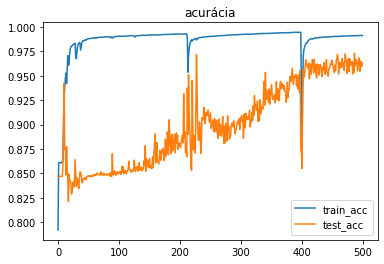

In [10]:
#Treinar o modelo por 500 épocas
EPOCHS=500
BATCH_SIZE=32

history = model.fit(train_data, train_labels , epochs=EPOCHS, 
                      batch_size = BATCH_SIZE,shuffle=True, 
                      validation_data=(test_data, test_labels))





Text(0.5, 1.0, 'Acurácia')

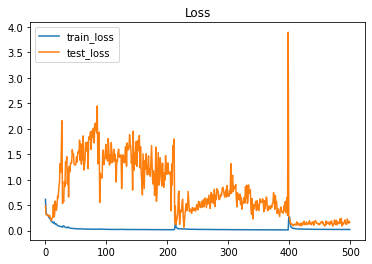

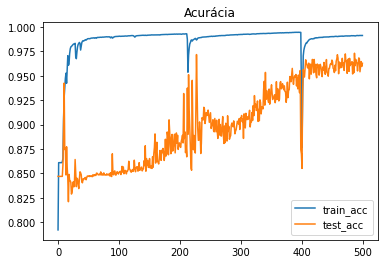

In [13]:
plt.figure()
plt.plot(history.history['loss'],label='train_loss')
plt.plot(history.history['val_loss'],label='test_loss')
plt.legend()
plt.title('Loss')
plt.figure()
plt.plot(history.history['acc'],label='train_acc')
plt.plot(history.history['val_acc'],label='test_acc')
plt.legend()
plt.title('Acurácia')

In [12]:
model.save(os.path.join('/content/gdrive/MyDrive/dados','DNN_lungs_segmentation.hdf5')) #Salvar o modelo